**IMPORT AND SETUPS**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

**DEFINE PINN MODEL**

In [2]:
class HestonPINN(nn.Module):
    def __init__(self):
        super(HestonPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

**PDE LOSS FUNCTION**

In [3]:
def heston_pde_loss(model, S, v, t, r=0.05, rho=-0.7, kappa=2.0, theta=0.04, sigma=0.3):
    S = S.clone().requires_grad_(True)
    v = v.clone().requires_grad_(True)
    t = t.clone().requires_grad_(True)

    x = torch.stack([S, v, t], dim=1)
    V = model(x)

    grads = grad(V, x, torch.ones_like(V), create_graph=True)[0]
    dV_dS = grads[:, 0]
    dV_dv = grads[:, 1]
    dV_dt = grads[:, 2]

    d2V_dS2 = grad(dV_dS, S, torch.ones_like(dV_dS), create_graph=True)[0]
    d2V_dv2 = grad(dV_dv, v, torch.ones_like(dV_dv), create_graph=True)[0]
    d2V_dSdv = grad(dV_dS, v, torch.ones_like(dV_dS), create_graph=True)[0]

    pde = dV_dt + 0.5 * v * S**2 * d2V_dS2 + rho * sigma * v * S * d2V_dSdv + \
          0.5 * sigma**2 * v * d2V_dv2 + r * S * dV_dS + kappa * (theta - v) * dV_dv - r * V

    return torch.mean(pde**2)

**TERMINAL LOSS**

In [4]:
def heston_terminal_loss(model, S, v, K=100):
    t1 = torch.ones_like(S)
    x = torch.stack([S, v, t1], dim=1)
    V_pred = model(x).squeeze()
    V_true = torch.maximum(S - K, torch.tensor(0.0))
    return torch.mean((V_pred - V_true)**2)


**MODEL TRAINING**

In [5]:
def train_heston(model, epochs=10000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        S = torch.rand(1000) * 200         # asset price [0, 200]
        v = torch.rand(1000) * 0.5         # variance [0, 0.5]
        t = torch.rand(1000)               # time [0, 1]

        loss_pde = heston_pde_loss(model, S, v, t)

        S_terminal = torch.linspace(0, 200, 1000)
        v_terminal = torch.ones_like(S_terminal) * 0.04
        loss_term = heston_terminal_loss(model, S_terminal, v_terminal)

        loss = loss_pde + loss_term
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"[Heston] Epoch {epoch} | Loss: {loss.item():.6f}")


**VISUALISATION**

In [6]:
def plot_heston_surface(model):
    S_vals = np.linspace(1, 200, 100)
    t_vals = np.linspace(0, 1, 100)
    v_val = 0.04  # fixed typical volatility

    S_grid, t_grid = np.meshgrid(S_vals, t_vals)
    S_flat = torch.tensor(S_grid.flatten(), dtype=torch.float32)
    t_flat = torch.tensor(t_grid.flatten(), dtype=torch.float32)
    v_flat = torch.ones_like(S_flat) * v_val

    x = torch.stack([S_flat, v_flat, t_flat], dim=1)

    with torch.no_grad():
        preds = model(x).reshape(S_grid.shape).numpy()

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S_grid, t_grid, preds, cmap='plasma')
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Time to Maturity")
    ax.set_zlabel("Option Price")
    ax.set_title("Heston PINN Option Price Surface")
    plt.show()


**RUN PIPELINE**

[Heston] Epoch 0 | Loss: 1676.172729
[Heston] Epoch 200 | Loss: 1016.179077
[Heston] Epoch 400 | Loss: 611.628479
[Heston] Epoch 600 | Loss: 382.585846
[Heston] Epoch 800 | Loss: 246.508835
[Heston] Epoch 1000 | Loss: 162.723221
[Heston] Epoch 1200 | Loss: 106.338905
[Heston] Epoch 1400 | Loss: 71.696815
[Heston] Epoch 1600 | Loss: 49.405674
[Heston] Epoch 1800 | Loss: 34.720982
[Heston] Epoch 2000 | Loss: 27.486868
[Heston] Epoch 2200 | Loss: 18.784281
[Heston] Epoch 2400 | Loss: 13.152717
[Heston] Epoch 2600 | Loss: 10.154955
[Heston] Epoch 2800 | Loss: 9.353917
[Heston] Epoch 3000 | Loss: 7.334820
[Heston] Epoch 3200 | Loss: 5.702573
[Heston] Epoch 3400 | Loss: 5.385800
[Heston] Epoch 3600 | Loss: 5.053154
[Heston] Epoch 3800 | Loss: 3.640854
[Heston] Epoch 4000 | Loss: 3.905198
[Heston] Epoch 4200 | Loss: 3.648414
[Heston] Epoch 4400 | Loss: 3.133462
[Heston] Epoch 4600 | Loss: 9.492700
[Heston] Epoch 4800 | Loss: 2.929097
[Heston] Epoch 5000 | Loss: 3.055426
[Heston] Epoch 5200 | 

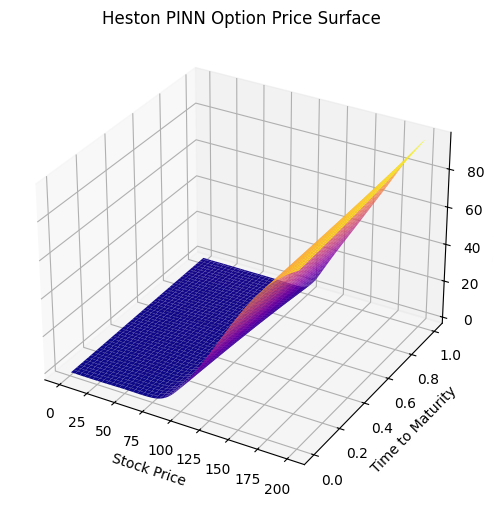

In [7]:
heston_model = HestonPINN()
train_heston(heston_model)
plot_heston_surface(heston_model)

**SAVE MODEL**

In [8]:
torch.save(heston_model.state_dict(), "heston_model.pth")